# 13. 결과 시각화

### t-SNE(t-distributed Stochastic Neighbor Embedding) 

실험이 완료되면 결과를 시각화 하는 것이 매우 중요하다. 하지만 이미지나 추출 된 피쳐들은 차원이 높기 때문에 각 피쳐들이 어떤 분포를 가지고 있는지 표현하기 어렵다. 다시 말해서, 우리가 시각적으로 표현할 수 있는 차원은 3차원이기 때문에 고차원의 벡터들을 3차원 이하의 저차원으로 바꿔야만 한다. 따라서 이를 위해 널리 쓰이는 방법 중 하나인 t-SNE을 구현해 본다.

In [1]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
cd/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch

/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch


In [4]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 13.1 데이터 불러오기

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


## 13.2 모델 불러오기


In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)


In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model.load_state_dict(torch.load('./models/cifar10_resnet18.pth'))
model.fc = Identity() #아이덴티티 매핑, 마지막에 분류기를 사용하지 않고, fc바로 전에 있는 avgpool레이어의 값을 그대로 가져오기
#즉 자기자신을 받아서 자기 자신을 반환하는 함수

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 13.4 t-SNE

In [13]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images) #512짜리 에버리지 풀링값을 저장함, 즉 512차원인 값이다.

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

In [14]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


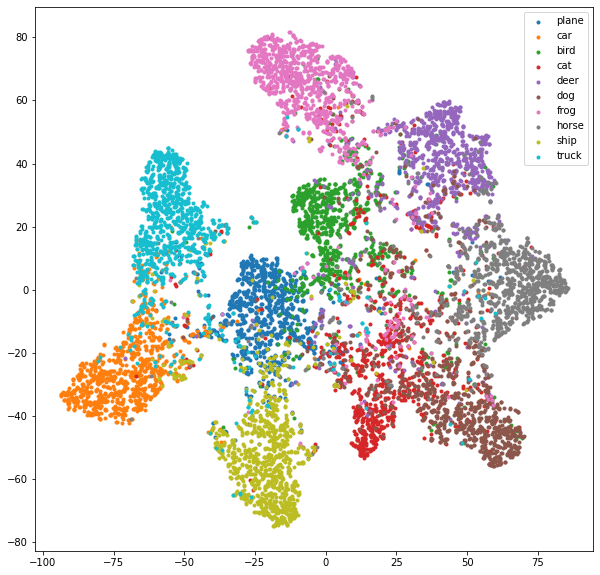

In [16]:
plt.figure(figsize=(10, 10))
cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label) #0(0열)은 x좌표, 1(1열)은 y좌표가 됩니다.
    
plt.legend()
plt.show()